In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import GaussianBlur, ToTensor, ToPILImage, RandomCrop, Compose, Resize, Normalize
from torchvision.datasets import CIFAR10, Flickr8k, CelebA
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
image_size = 28

# Gaussian Pyramid Constants
num_scales = 3
scale_factor = 2

# Define data transformations
transform = Compose([
    RandomCrop(image_size),
    ToTensor()
])

# Load CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create data loader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [3]:
# Define the network architecture with feature pyramid
class CompletionModel(nn.Module):
    def __init__(self, num_scales=3):
        super(CompletionModel, self).__init__()
        self.num_scales = num_scales

        # Define layers for each scale in the feature pyramid
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.channel_reducers = nn.ModuleList()  # 1x1 convolution layers to reduce channels
#         self.downsamplers = nn.ModuleList()
#         self.upsamplers = nn.ModuleList()
        
        for i in range(num_scales):
            encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU()
            )
            self.encoders.append(encoder)

            decoder = nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
                nn.Tanh()
            )
            self.decoders.append(decoder)
            
            channel_reducer = nn.Conv2d(3, 256, kernel_size=1)  # 1x1 convolution layer to reduce channels
            self.channel_reducers.append(channel_reducer)
            
            
        self.downsampler = nn.Upsample(scale_factor=1/scale_factor, mode='bilinear', align_corners=False)
        #self.downsamplers.append(downsampler)
            
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)
        #self.upsamplers.append(upsampler)

    def forward(self, x):
        # Initialize list to store features from each scale
        features = []

        # Forward pass through each scale in the feature pyramid
        for i in range(self.num_scales):
            encoder_output = self.encoders[i](x)
            features.append(encoder_output)
            #downsample = nn.Upsample(scale_factor=1/scale_factor**i, mode='bilinear', align_corners=False)
            x = self.downsampler(x)
            #x = nn.functional.max_pool2d(encoder_output, kernel_size=2, stride=2)

#         # Concatenate features from all scales
#         concatenated_features = torch.cat(features, dim=1)

        # Decode the concatenated features
        shape_feats = list(features[-1].shape)
        shape_feats[1] = 3
        prev_output = torch.zeros(shape_feats).to(device)
        
#         for f in features:
#             print(f.shape)
        
        for i in range(self.num_scales):
            prev_output = self.channel_reducers[i](prev_output)
            #print(i, prev_output.shape, features[self.num_scales - i - 1].shape)
            prev_output += features[self.num_scales - i - 1]#features[self.num_scales - i - 1]
            decoder_output = self.decoders[i](prev_output)
            #features.append(encoder_output)
            #upsampler = nn.Upsample(scale_factor=scale_factor**i, mode='bilinear', align_corners=False)
            if i+1< self.num_scales:
                prev_output = self.upsampler(decoder_output)
            #x = nn.functional.max_pool2d(encoder_output, kernel_size=2, stride=2)

#         decoded = self.decoders[0](concatenated_features)
        #print(decoder_output.shape)
        return decoder_output


In [10]:
model = CompletionModel().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in dataloader:
        images = images.to(device)
        
        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        # Forward pass and loss calculation
        completion_images = model(occluded_image.to(device))
        loss = criterion(completion_images, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Compute the average loss for the epoch
    average_loss = running_loss / len(dataloader)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Generate completions for test images
model.eval()
pass

Epoch [1/10], Loss: 0.0108
Epoch [2/10], Loss: 0.0068
Epoch [3/10], Loss: 0.0065
Epoch [4/10], Loss: 0.0063
Epoch [5/10], Loss: 0.0061
Epoch [6/10], Loss: 0.0060
Epoch [7/10], Loss: 0.0059
Epoch [8/10], Loss: 0.0059
Epoch [9/10], Loss: 0.0058
Epoch [10/10], Loss: 0.0058


CompletionModel(
  (encoders): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (decoders

In [ ]:
from IPython.display import display, HTML

# Define test transformations
test_transform = Compose([
    ToTensor()
])

# Load CIFAR-10 test dataset
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Create test data loader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    for images, _ in test_dataloader:
        images = images.to(device)
        
        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        
        ########
        
        # Generate completions using the model
        completions = model(occluded_image.to(device))

        # Convert tensors to PIL images for visualization
        to_pil = ToPILImage()
        original_img = to_pil(occluded_image.cpu().squeeze(0))
        completed_img = to_pil(completions.cpu().squeeze(0))
        
        # Define the HTML style for larger images
        html_style = "<style>img { max-width: 100%; height: auto; }</style>"

        # Display the original and completed images with larger size
#         display(HTML(html_style))

#         # Display the original and completed images
#         display(original_img)
#         display(completed_img)

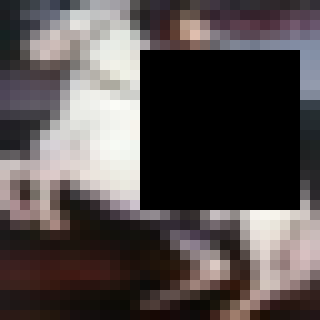

In [12]:
from PIL import Image
original_img.resize((original_img.width * 10,original_img.height * 10),
                                                    Image.NEAREST)


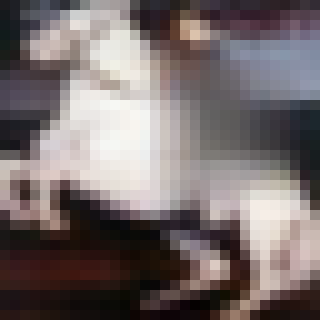

In [13]:
completed_img.resize((completed_img.width * 10,completed_img.height * 10),
                                                    Image.NEAREST)

## Notes

Can try with other datasets as well available here: https://pytorch.org/vision/0.9/datasets.html

Currently, CelebA hit some download limit so couldn't try. can try later again